## Character Recognition - MNIST Dataset - Simple Neural Network - No Preprocessing

This will be a quick demonstration of building a conventional fully-connected neural network for character recognition using Keras.

The MNIST dataset provides us with a large set of labelled images that are at a low-resolution, which keeps the training time reasonable, even on a modest CPU. More information and raw data available at http://yann.lecun.com/exdb/mnist/, although the files needed are in the repository. 

The dataset is broken into 4 files, sets of images and labels for both the training and test sets. 

Firstly we import the various libraries we will need:


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import struct

from keras.layers import Flatten, Dense
from keras.models import Sequential, Model
from keras import optimizers
from numpy.random import seed
seed(1)




Using TensorFlow backend.


The dataset files are not in an immediately useable format. We will use the following function to read the files into arrays. 

In [2]:
# The MNIST data is provided in a file format that needs to be read before the data can be fed to the neural network. 
def read_data(image_filename, label_filename):
    
    #Create arrays to store labels and pixel data
    label_array = []
    image_array = []
    
    # Load everything in some numpy arrays
    with open(label_filename, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(image_filename, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

    for i in range(len(lbl)):
        label_array.append(lbl[i])
        image_array.append(np.ndarray.flatten(img[i]))
    
    #Convert arrays to np.array
    image_array = np.array(image_array)
    
    return(image_array, label_array)
    
    


Let's read in the data and have a look at it:

In [3]:
train_images, train_labels = read_data('train-images.idx3-ubyte', 'train-labels.idx1-ubyte')
print('Shape of train_labels = ',np.shape(train_labels))
print('Shape of train_images = ', np.shape(train_images))


print('train_labels[0:5] = ', train_labels[0:5])

print(train_images[0])


Shape of train_labels =  (60000,)
Shape of train_images =  (60000, 784)
train_labels[0:5] =  [5, 0, 4, 1, 9]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255
 247 127   0   0   0   0   0   0   0   0   0   0   0   0  30  36  94 154
 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0   0   0
   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82
  82  56  39   

Note each is an integer between 0 and 9. As the network will output probabilities between 0 and 1 for each character, 
let's change the labels to be 'one-hot' encoded. 

In [4]:
def make_one_hot(labels):

    labels_one_hot = np.zeros((len(labels),10))

    for i in range(len(labels)):
        labels_one_hot[i,labels[i]] = 1
    
    return(labels_one_hot)

train_labels = make_one_hot(train_labels)
                                

Let's have a look at the first 5 labels now. Based on the prior printout, we should have 1's in the 6th, 1st, 5th, 2nd and last positions. 

In [5]:
print(train_labels[0:5])

[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


Perfect! Now we can proceed to build the model. 

In [6]:
def build_model(input_shape, num_output_nodes, lr, size):
    
    model = Sequential()
    
    model.add(Dense(size[0], input_shape = input_shape, activation = 'relu'))
    
    for i in range(1,len(size)):
        model.add(Dense(size[i], activation = 'relu'))
    
    model.add(Dense(num_output_nodes, activation = 'softmax')) 
    
    adam = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999)
    
    model.compile(loss = 'mse', optimizer = adam, metrics=['accuracy'])
    
    model.summary()
    
    return model

model = build_model((784,), 10, 0.001, [16,16])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                12560     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                170       
Total params: 13,002
Trainable params: 13,002
Non-trainable params: 0
_________________________________________________________________


Now let's train the model. A validation split of 0.1 is used. This means that 10% (6000 images) is not used for training but 
instead is used to check the performance after each epoch. This will allow us to detect overfitting to the training set. We'll plot the accuracy of both the training and validation sets (you could plot the loss instead). If you wish to watch the change in loss and accuracy during training, set verbose to 1)

In [7]:
history = model.fit(train_images, train_labels, batch_size=5120, validation_split=0.1, epochs=400, verbose=0)


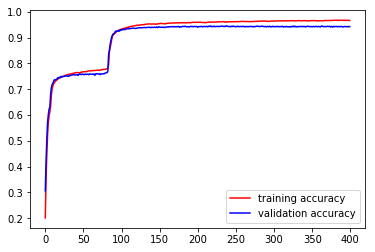

0.942000007629


In [8]:
plt.plot(history.history['acc'], 'r', label='training accuracy')
plt.plot(history.history['val_acc'], 'b', label='validation accuracy')

plt.title('Training Performance by Network Size')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(history.history['val_acc'][399])


After 400 epochs, we have reached a validation accuracy of around 95% (although note that this could very between instances due to random selection of the validation set and the random initialization of the network). It is worth noting that the loss and accuracy for the validation set are similar to those of the training set, so we are not overfitting excessively, although it would appear that any further training is of little benefit with the parameters used. 

Let's investigate the effect of learning rate. The initial learning rate of 0.001 was a good starting point, but we might be able to get either a similar result in less epochs with a larger learning rate, or a better end result with a smaller one. Batch size is kept constant.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                12560     
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                170       
Total params: 13,002
Trainable params: 13,002
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 16)                12560     
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_

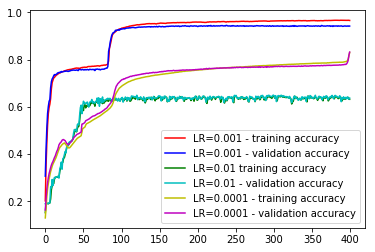

In [9]:
model_0_001 = model
model_0_01 = build_model((784,), 10, 0.01, [16,16])
model_0_0001 = build_model((784,), 10, 0.0001, [16,16])

history_0_001 = history
history_0_01 = model_0_01.fit(train_images, train_labels, batch_size=5120, validation_split=0.1, epochs=400, verbose=0)
history_0_0001 = model_0_0001.fit(train_images, train_labels, batch_size=5120, validation_split=0.1, epochs=400, verbose=0)

plt.plot(history.history['acc'], 'r', label='LR=0.001 - training accuracy')
plt.plot(history.history['val_acc'], 'b', label='LR=0.001 - validation accuracy')
plt.plot(history_0_01.history['acc'], 'g', label='LR=0.01 training accuracy')
plt.plot(history_0_01.history['val_acc'], 'c', label='LR=0.01 - validation accuracy')
plt.plot(history_0_0001.history['acc'], 'y', label='LR=0.0001 - training accuracy')
plt.plot(history_0_0001.history['val_acc'], 'm', label='LR=0.0001 - validation accuracy')
plt.legend(loc='best')
plt.title('Training Performance by Network Size')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


It appears our initial learning rate was probably about right. The smaller learning rate might have hit a slightly better final result eventually, but even after 1000 epochs it had not reached the level of the 0.001 learning rate

Now let's investigate the effect of network size. The first network we used had 2 hidden layers, each containing 16 layers. We'll run a smaller (single layer, 16 nodes), a 3 layer network (3 hidden layers, 16 nodes each) and a 2 layer network but with twice as many nodes per layer and compare results. We will use the best learning rate from the prior example (0.001)
 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 16)                12560     
_________________________________________________________________
dense_32 (Dense)             (None, 10)                170       
Total params: 12,730
Trainable params: 12,730
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 16)                12560     
_________________________________________________________________
dense_34 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_35 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_

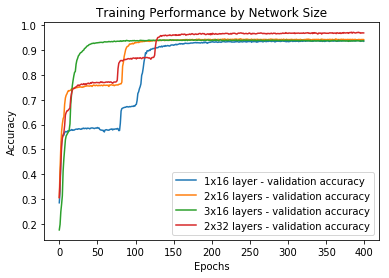

0.935499999523 0.942000007629 0.937499991258 0.968999986649


In [18]:
model_1_layer = build_model((784,), 10, 0.001, [16])
model_3_layers = build_model((784,), 10, 0.001, [16,16,16])
model_2_32_layers = build_model((784,), 10, 0.001, [32,32])

history_2_layers = history
history_1_layer = model_1_layer.fit(train_images, train_labels, batch_size=5120, validation_split=0.1, epochs=400, verbose=0)
history_3_layers = model_3_layers.fit(train_images, train_labels, batch_size=5120, validation_split=0.1, epochs=400, verbose=0)
history_2_32_layers = model_2_32_layers.fit(train_images, train_labels, batch_size=5120, validation_split=0.1, epochs=400, verbose=0)

plt.plot(history_1_layer.history['val_acc'], 'C0', label='1x16 layer - validation accuracy')
plt.plot(history_2_layers.history['val_acc'], 'C1', label='2x16 layers - validation accuracy')
plt.plot(history_3_layers.history['val_acc'], 'C2', label='3x16 layers - validation accuracy')
plt.plot(history_2_32_layers.history['val_acc'], 'C3', label='2x32 layers - validation accuracy')

plt.title('Training Performance by Network Size')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

print(history_1_layer.history['val_acc'][399],
history_2_layers.history['val_acc'][399],
history_3_layers.history['val_acc'][399],
history_2_32_layers.history['val_acc'][399])


You can see that there is little final performance benefit to the additional layers, although larger layers does significantly improve the performance. Let's see if the effect extends even further.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_47 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_48 (Dense)             (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


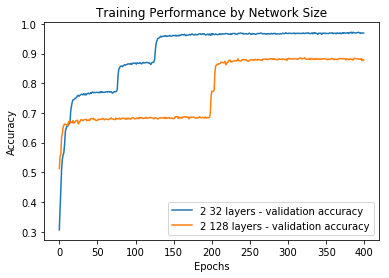

In [21]:
model_2_128_layers = build_model((784,), 10, 0.001, [128,128])

history_2_128_layers = model_2_128_layers.fit(train_images, train_labels, batch_size=5120, validation_split=0.1, epochs=400, verbose=0)

plt.plot(history_2_32_layers.history['val_acc'], 'C0', label='2 32 layers - validation accuracy')
plt.plot(history_2_128_layers.history['val_acc'], 'C1', label='2 128 layers - validation accuracy')

plt.title('Training Performance by Network Size')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()


In [22]:
print(history_2_32_layers.history['val_acc'][399])
print(history_2_128_layers.history['val_acc'][399])

0.968999986649
0.878166656494


It looks like the larger network is of no benefit, and may in fact be detrimental. 

Using our best network (2 hidden layers of 32 nodes), let's have a look at the images that the model is getting wrong.  Let's look at the first 10 images the model is incorrectly classifying. 

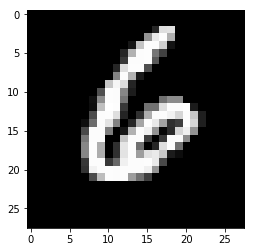

Label =  6 Prediction =  8


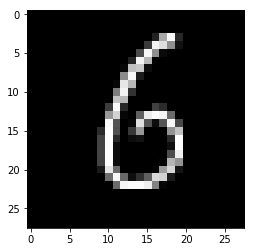

Label =  6 Prediction =  5


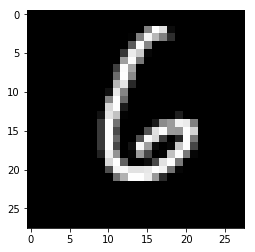

Label =  6 Prediction =  0


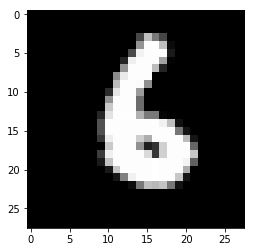

Label =  6 Prediction =  8


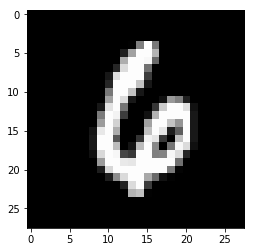

Label =  6 Prediction =  0


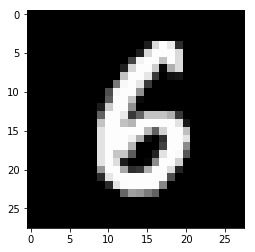

Label =  6 Prediction =  8


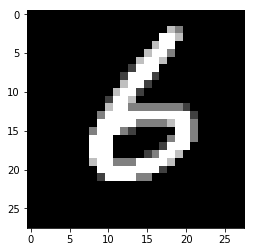

Label =  6 Prediction =  5


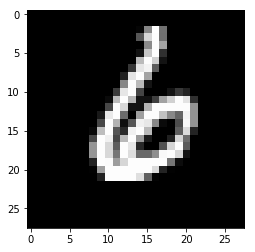

Label =  6 Prediction =  8


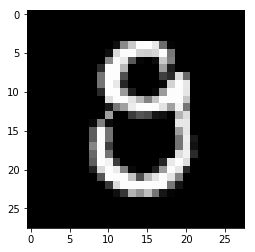

Label =  9 Prediction =  0


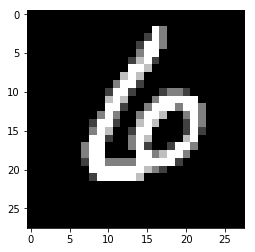

Label =  6 Prediction =  0


In [23]:
numwrong = 0
a = 0
wrong_indexes = [] #List of indexes of wrong predictions from training set
predictions = model_2_128_layers.predict(train_images)

while numwrong<10:
    if np.argmax(predictions[a]) != np.argmax(train_labels[a]):
        wrong_indexes.append(a)
        numwrong += 1
    a += 1

for i in wrong_indexes:
    plt.imshow(np.reshape(train_images[i], (28,28)), cmap='gray')
    plt.show()
    print('Label = ', np.argmax(train_labels[i]), 'Prediction = ', np.argmax(predictions[i]))



It is clear that the misclassified images are poorly drawn, and in many cases would not be classified correctly by a human. It is therefore unlikely that the performance could be improved substantially from this point. 

### Performance on the test set

Finally, let's see how our model performs on the test set. It should be close to the validation set performance. 



In [14]:
test_images, test_labels = read_data('t10k-images.idx3-ubyte', 't10k-labels.idx1-ubyte')

test_labels = make_one_hot(test_labels)

predictions = model_2_128_layers.evaluate(test_images, test_labels)





10000/10000 [==============================] - 0s 28us/step


In [15]:
print(model_2_128_layers.metrics_names)
print(predictions)


['loss', 'acc']
[0.0045817198382155791, 0.9768]


Accuracy on the test set is approximately 97.5%. 

Again, let's have a look at the images the model is incorrectly classifying. 

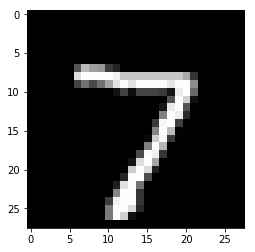

Label =  7 Prediction =  9


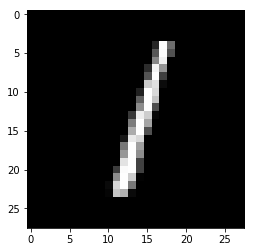

Label =  1 Prediction =  2


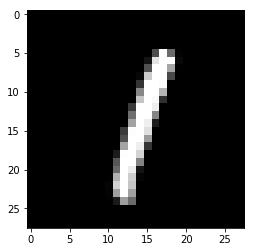

Label =  1 Prediction =  9


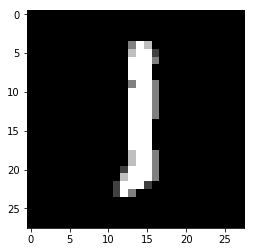

Label =  1 Prediction =  9


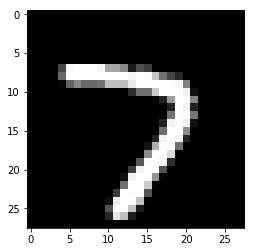

Label =  7 Prediction =  2


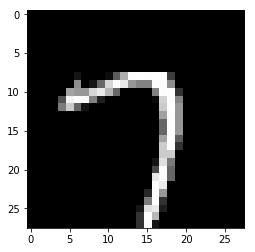

Label =  7 Prediction =  2


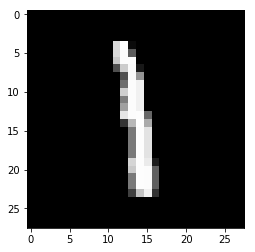

Label =  1 Prediction =  9


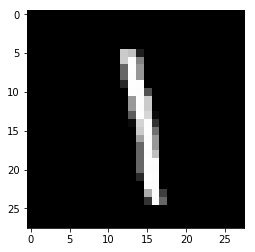

Label =  1 Prediction =  9


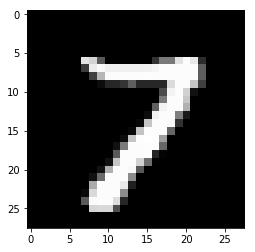

Label =  7 Prediction =  9


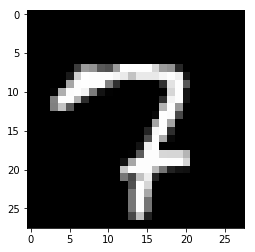

Label =  7 Prediction =  2


In [16]:


numwrong = 0
a = 0
wrong_indexes = [] #List of indexes of wrong predictions from training set
predictions = model_2_32_layers.predict(test_images)

while numwrong < 10:
    if np.argmax(predictions[a]) != np.argmax(test_labels[a]):
        wrong_indexes.append(a)
        numwrong += 1
    a += 1

for i in wrong_indexes:
    plt.imshow(np.reshape(test_images[i], (28,28)), cmap='gray')
    plt.show()
    print('Label = ', np.argmax(test_labels[i]), 'Prediction = ', np.argmax(predictions[i]))


It is noted that while some of the mischaracterised images are poorly drawn, some are reasonably drawn but significantly angled. Preprocessing the training data to rotate some of the training images slightly may improve performance. 


### Summary

A conventional neural network was trained to recognise digit characters in the MNIST dataset. It was found that a larger neural network improved performance, but only to a point. It was also noted that a significant proportion of the characters the network mislabelled were misdrawn, and would not be consistently classified correctly by humans. The test-set accuracy was approximately 96% (may vary between trainings). Further improvement could be achieved by preprocessing the training data, in particular to include a small range of rotation. This will be tested in a future study.

